# The Music of the Sphere: 100 Posterior Sample Planck CMB Temperature Maps, and their Spherical Harmonic Decompositions

*Laurence Perreault Levasseur, Phil Marshall, and Roger Blandford, January 2016*

In this notebook we generate a mock Universe and use the likelihood from Music allegro paper to reconstruct the 3D map of the interior sphere.

To do this we make use of 100 posterior sample Commander Planck CMB temperature maps to calculate the $a_lm$'s covariance matrix, and use a prior for the $f_n$'s constructed from a primordial power spectrum with amplitude given by Planck and a spectral index of 0.97. To do the reconstruction we do not use a mask on the T map and use SVD to deal with all ill-conditioned matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import beatbox
import os.path

1


In [7]:
You=beatbox.Multiverse(truncated_nmax=3, truncated_nmin=1, truncated_lmax=10, truncated_lmin=1)
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  122  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 5.4e-06


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


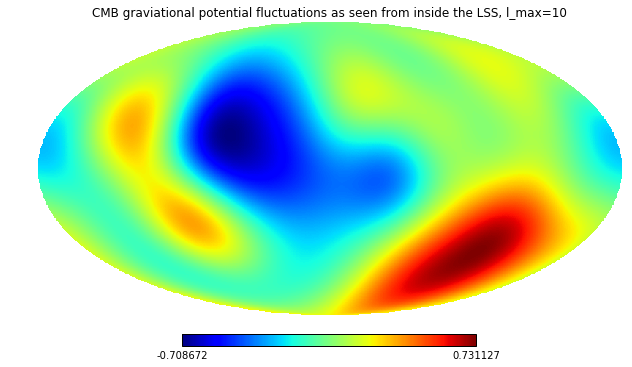

In [8]:
# Plot the generated T map
%matplotlib inline
import healpy as hp
beatbox.You.all_simulated_universes[-1].show_CMB_T_map(from_perspective_of="observer")

In [9]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated
if not os.path.isfile('data/covCyy.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix()
else:
    beatbox.You.load_covariance_matrix(filename='covCyy.txt')

In [10]:
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

In [21]:
# Use the simulated Universe as mock data
# First, generate one realization of noise
noise = beatbox.You.generate_one_realization_of_noise()
# Add the noise to the realization of the sky map
datamap=beatbox.You.all_simulated_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)+noise
datamap=datamap.T

In [23]:
# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


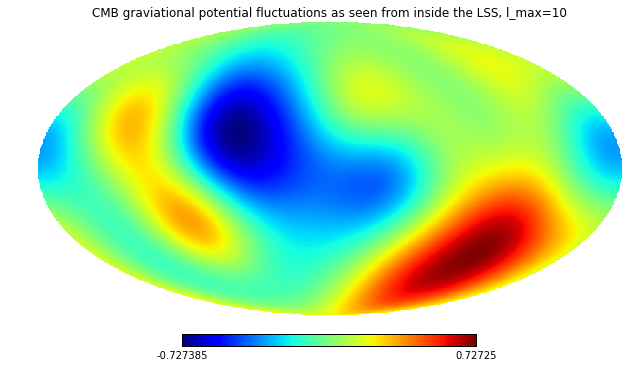

In [24]:
# Give those reconstructed f_n's to one realization of the Universe
We=beatbox.Universe()
We.fn=beatbox.You.reconstrunct_fn
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")

In [27]:
# Plot the residuals:
Residuals=We.Tmap-beatbox.You.all_simulated_universes[-1].Tmap


In [25]:
# From those f_n's build the 3d spatial potential:
ind = np.where(We.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = We.kx[ind], We.ky[ind], We.kz[ind]


RealPhi = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase = k_x[i] * We.x + k_y[i] * We.y + k_z[i] * We.z
    RealPhi += (We.fn[i] * np.cos(phase)+We.fn[len(k_x)-1-i]*np.sin(phase))*We.Deltak**3
    We.phi = RealPhi.real

yt : [INFO     ] 2016-01-21 15:09:06,449 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-01-21 15:09:06,450 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2016-01-21 15:09:06,451 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2016-01-21 15:09:06,452 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2016-01-21 15:09:06,453 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2016-01-21 15:09:06,492 Loading field plugins.
yt : [INFO     ] 2016-01-21 15:09:06,493 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-01-21 15:09:06,494 Loaded astro (15 new fields)
yt : [INFO     ] 2016-01-21 15:09:06,495 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-01-21 15:09:06,498 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-01-21 15:09:06,502 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-01-21 15:09:06,504 Loaded geometric (112 ne

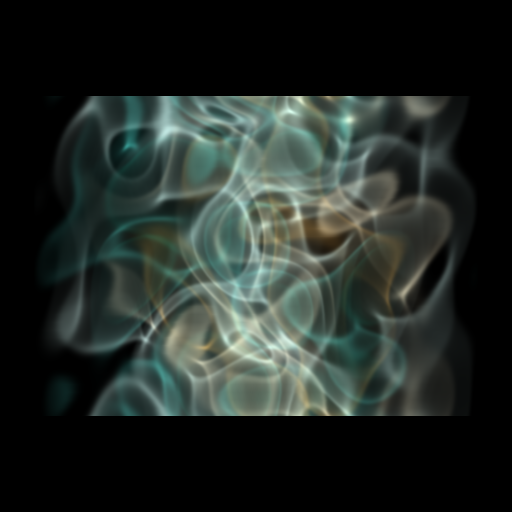

In [26]:
import yt 
We.Pdist=1
We.Pmax=2*np.pi
We.show_potential_with_yt(angle=np.pi/2,  N_layer=5, cmap='BrBG', show3D=1)